<a href="https://www.kaggle.com/code/asmaaabdelazizradwan/mri-tumar-recognition?scriptVersionId=211187465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [3]:
!pip install -q -U keras_tuner

In [5]:
import os
import numpy as np
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import io
from PIL import Image
from warnings import filterwarnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

# Prepare the training and testing datasets

In [3]:
X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']

#resizing image to 150*150 pixel
image_size = 150

#Training dataset
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
#Testing dataset
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:02<00:00, 131.97it/s]


In [4]:
print(f"Total number of images in X_train: {X_train.shape[0]}")
print(f"Total number of labels in y_train: {y_train.shape[0]}")

print(f"Shape of images: {X_train.shape[1:]}")

Total number of images in X_train: 7023
Total number of labels in y_train: 7023
Shape of images: (150, 150, 3)


# visulization of tumor type counts


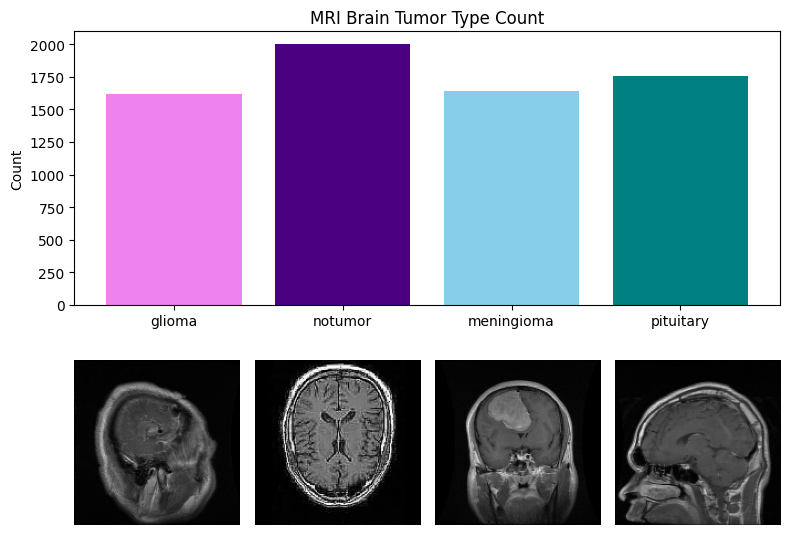

In [5]:
label_counts = {} #an empty dictionary
for label in labels:
    count = np.sum(y_train == label)
    label_counts[label] = count  # Add the count to the dictionary
    
plt.figure(figsize=(8, 6))

colors = sns.color_palette("Blues", len(labels))
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
plt.ylabel('Count')
plt.title('MRI Brain Tumor Type Count')

# Plot sample images from each Type
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) #location of image
            plt.imshow(X_train[j]) #to show image
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

# Split data into train,test and validation

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# One-Hot Encoding Labels

In [7]:
# Convert y_train, y_valid, and y_test labels to one-hot encoded format after the split
y_train = np.array(pd.get_dummies(y_train))
y_valid = np.array(pd.get_dummies(y_valid))
y_test = np.array(pd.get_dummies(y_test))


In [8]:
# Print shapes of splits
print(f'X_train shape: {X_train.shape}\n'
      f'y_train shape: {y_train.shape}\n'
      f'X_test shape: {X_test.shape}\n'
      f'y_test shape: {y_test.shape}\n'
      f'X_valid shape: {X_valid.shape}\n'
      f'y_valid shape: {y_valid.shape}')

X_train shape: (5688, 150, 150, 3)
y_train shape: (5688, 4)
X_test shape: (703, 150, 150, 3)
y_test shape: (703, 4)
X_valid shape: (632, 150, 150, 3)
y_valid shape: (632, 4)


# Normalize pixels

In [9]:
# Normalize pixel values of training images to the range [0,1]
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


# Data Augmentation

In [10]:
def model_builder(hp):
    # Define augmentation layers with hyperparameters from Keras Tuner
    data_augmentation = tf.keras.Sequential([
        preprocessing.Rescaling(1./255),  # Rescale the images from [0, 255] to [0, 1]
        preprocessing.RandomRotation(hp.Float('rotation_range', min_value=0.1, max_value=0.3, step=0.05)),  # Random rotation
        preprocessing.RandomWidth(hp.Float('width_shift_range', min_value=0.1, max_value=0.3, step=0.05)),  # Random width shift
        preprocessing.RandomHeight(hp.Float('height_shift_range', min_value=0.1, max_value=0.3, step=0.05)),  # Random height shift
        preprocessing.RandomZoom(hp.Float('zoom_range', min_value=0.1, max_value=0.3, step=0.05)),  # Random zoom
        preprocessing.RandomFlip("horizontal"),  # Random flip
        preprocessing.RandomContrast(hp.Float('contrast_range', min_value=0.1, max_value=0.5, step=0.05)),  # Random contrast adjustment
        preprocessing.RandomBrightness(hp.Float('brightness_range', min_value=0.1, max_value=0.5, step=0.05))  # Random brightness adjustment
    ])

# First: Vgg 16
VGG16 is a convolutional neural network architecture with 16 deep layers, 13 convolutional layers, 3 fully connected layers, and 5 max pooling layers

The model starts with an input layer specifying the shape (150x150x3) for RGB images. It then has several convolutional layers (Conv2D) followed by max pooling and dropout layers. The number of filters increases from 16 to 32 to 64 as the network deepens. After the convolutional layers, the output is flattened and passed through dense layers. The final layer has 4 neurons with softmax activation for 4-class classification..

In [11]:
# Define the model builder function for hyperparameter tuning
def model_builder(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    # Make initial layers trainable as a tunable hyperparameter
    for layer in base_model.layers[:hp.Int('trainable_layers', min_value=5, max_value=len(base_model.layers), step=5)]:
        layer.trainable = True

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu')(x)
    output = Dense(4, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

    # Compile the model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    return model

In [2]:
# Initialize the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     factor=3,
                     max_epochs=10)

NameError: name 'kt' is not defined

In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_split=0.1, verbose=1)

Trial 10 Complete [00h 01m 22s]
val_accuracy: 0.29349735379219055

Best val_accuracy So Far: 0.9701230525970459
Total elapsed time: 00h 14m 04s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
5                 |10                |trainable_layers
0.4               |0.4               |dropout_rate
256               |256               |dense_units
0.01              |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 14,847,044 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - accuracy: 0.2575 - loss: 5420125184.0000 - val_accuracy: 0.2935 - val_loss: 1.3797
Epoch 2/2
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2841 - loss: 1.3821

In [1]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

NameError: name 'tuner' is not defined

In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Model Training

In [ ]:
history = model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=15),
    validation_data=(X_valid, y_valid),
    epochs=10, 
    callbacks=[
        TensorBoard(log_dir='logs'),
        ModelCheckpoint("vgg16_best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_delta=0.0001, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]
)

In [ ]:
# Evaluate the final model
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Ensure we're using the VGG16 model
model = tf.keras.models.load_model("vgg16_best_model.keras")  # Load the best saved model

y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('VGG16 Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

print(classification_report(y_true_test, y_pred_test))

random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

# Display the results
print(f"\nPredicted label: {predicted_label}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Actual label: {labels[y_true_test[random_index]]}")

plt.imshow(random_img)
plt.axis('off')
plt.show()

In [ ]:
# Save the final model
model.save("vgg16_best_model.keras")